<a href="https://colab.research.google.com/github/AllardQuek/Job-Recommendation/blob/main/JobRec_2_DT_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Job Recommendation for Undergraduates

Based on:
1. https://www.tensorflow.org/decision_forests/tutorials/beginner_colab#training_a_ranking_model
2. https://www.tensorflow.org/decision_forests/tutorials/intermediate_colab

In [ ]:
from IPython.core.magic import register_line_magic
from IPython.display import Javascript

In [ ]:
#@title

# Some of the model training logs can cover the full
# screen if not compressed to a smaller viewport.
# This magic allows setting a max height for a cell.
@register_line_magic
def set_cell_height(size):
  display(
      Javascript("google.colab.output.setIframeHeight(0, true, {maxHeight: " +
                 str(size) + "})"))

In [ ]:
%set_cell_height 300
!pip3 install tensorflow_decision_forests --upgrade

<IPython.core.display.Javascript object>

     |████████████████████████████████| 6.2MB 16.9MB/s 


Install [Wurlitzer](https://pypi.org/project/wurlitzer/). It can be used to show
the detailed training logs. This is only needed in colabs.

In [ ]:
!pip install wurlitzer

Now let's import all the packages we need.

In [ ]:
import tensorflow_decision_forests as tfdf

import os
import numpy as np
import pandas as pd
import tensorflow as tf
import math

try:
  from wurlitzer import sys_pipes
except:
  from colabtools.googlelog import CaptureLog as sys_pipes

In [ ]:
# Check the version of TensorFlow Decision Forests
print("Found TensorFlow Decision Forests v" + tfdf.__version__)

Found TensorFlow Decision Forests v0.1.7


## Matchin Data

In [ ]:
dataset_df = pd.read_excel("/content/drive/MyDrive/Jobs Internships/Matchin Internship/AI ML/Datasets/100datapoints-1.xlsx")
dataset_df.head()

,No.,Name,Current Job Title with Company,Current Job Description,Past Job/Internship Experience 1,Description,Past Internship Experience 2,Description.1,Past Internship Experience 3,Description.2,Skills,School,Unnamed: 12
0,1,Eda Tan,Software Analyst at JPMorgan Chase & Co,NIL,Software Developer at LiveMore,NIL,NIL,NIL,NIL,NIL,NIL,NIL,NaN
1,2,Amanda Lee,Systems Engineer at HP,NIL,Intern at Embraer,NIL,NIL,NIL,NIL,NIL,NIL,NIL,NaN
2,3,Byron Elton Tan,Engineer (Vehicle Systems) at HTX (Home Team S...,NIL,Engineer Vehicle Systems at MHA,NIL,NIL,NIL,NIL,NIL,NIL,NIL,NaN
3,4,Kavya Nair,Graduate Design Engineer at Dyson,Design Engineer,Executive Engineer at SMRT,NIL,NIL,NIL,NIL,NIL,NIL,NIL,NaN
4,5,Seung Kyu Kim,Siri Annotation Analyst AI/ML at Apple,NIL,Freelance Translator at MMD Singapore,NIL,NIL,NIL,NIL,NIL,NIL,NIL,NaN


## Preprocessing

In [ ]:
def split_it(title):
    # Let's get only the title without the company for now
    return title.partition(" at ")[0].strip()

In [ ]:
dataset_df["CurrentJobTitle"] = dataset_df["Current Job Title with Company"].apply(split_it)
dataset_df["Past1"] = dataset_df["Past Job/Internship Experience 1"].apply(split_it)
dataset_df["Past2"] = dataset_df["Past Internship Experience 2"].apply(split_it)
dataset_df["Past3"] = dataset_df["Past Internship Experience 3"].apply(split_it)

dataset_df.sample(10)

,No.,Name,Current Job Title with Company,Current Job Description,Past Job/Internship Experience 1,Description,Past Internship Experience 2,Description.1,Past Internship Experience 3,Description.2,Skills,School,Unnamed: 12,CurrentJobTitle,Past1,Past2,Past3
13,14,Pranjal Verma,Lead Engineer at Farme,Farme was founded to innovate and bring fully ...,Product Design Engineer at Ideagen,NIL,Clinic Assistant at NUH,NIL,NIL,NIL,"Research, Microsoft Excel, Photoshop, Research...",SUTD Biomedical Engineering,NaN,Lead Engineer,Product Design Engineer,Clinic Assistant,NIL
76,77,Samuel Samsudin Ng,R&D Engineer at STMicroeletronics,"- Audio and DSP algorithm development, impleme...",Senior DSP System Design Engineer at STMicroel...,[ ] Assist in analysing of Serious Reportable ...,NIL,NIL,NIL,NIL,"Research, SolidWorks, C++, FDM, Strategic Plan...",National University of Singapore,Biomedical/Medical Engineering,R&D Engineer,Senior DSP System Design Engineer,NIL,NIL
92,93,Andy Soh,Strategy & Consulting at Accenture,- IT Talent Strategy\n - B2B2X Go-to-Market St...,Chief Operations Officer at The Global Citizen...,• Scraped four years’ worth of central bank st...,Data Analyst Intern at Shell,• Developed a consistent pricing strategy to q...,Student Consultant at SMU,• Developed a data analytics framework to exam...,"Microsoft Office, Management, Social Media, Re...",Singapore Management University,Economics,Strategy & Consulting,Chief Operations Officer,Data Analyst Intern,Student Consultant
58,59,YuLong L.,Data Analyst at Tencent,NIL,Data Analyst and Business Intelligence Intern ...,NIl,Software Engineer Intern at JPMorgan Chase & Co.,NIL,Project Management Intern at PulseSync,NIL,"Team Leadership, Interpersonal, Microsoft Word...",Singapore Management University,Information Systems,Data Analyst,Data Analyst and Business Intelligence Intern,Software Engineer Intern,Project Management Intern
96,97,Jasvin Wuu,Executive Civil Engineer at Urban Redevelopmen...,NIL,Engineer at Arup,• Coordinated regional end-to-end quote delive...,Commercial Channel Program Intern at Cisco,• Motivated 1000+ APAC midmarket Partners over...,Corporate Strategy Intern at SGX,• Contributed insights on a $2 million M&A tar...,"Microsoft Office, Microsoft Excel, Teamwork, R...",National University of Singapore,Economics,Executive Civil Engineer,Engineer,Commercial Channel Program Intern,Corporate Strategy Intern
6,7,Wen Ting Leong,Associate Product Manager at Shopee\n,Listing Department in Shopee,Project Engineering Intern at Ramboll Manageme...,NIL,NIL,NIL,NIL,NIL,"SolidWorks, Adobe Photoshop, Adobe Illustrator...",SUTD Mechanical Engineering,NaN,Associate Product Manager,Project Engineering Intern,NIL,NIL
36,37,Albert Suryanto,Data Scientist at Bambu B2B Robo Advisor,Bambu is the global leader in digital wealth t...,Software Engineer at nucon.io,NIL,Coding Course Instructor at First Code Academy,• Lead Instructor for coding lessons conducted...,SAP Leonardo Machine Learning - Business Devel...,• Restructured and improved the weekly Machine...,"Data Visualization, Data Analysis, Tableau, R,...",SUTD Systems Engineering,NaN,Data Scientist,Software Engineer,Coding Course Instructor,SAP Leonardo Machine Learning - Business Devel...
7,8,Dominic Cordeiro,Software Engineer at NCS Group,Developed backend APIs for usage by the front ...,Summer Intern NCS Group,Vehicle Systems Engineer,Image Processing 3D Intern at Panasonic R&D Ce...,Integrated the hardware and software systems t...,Technik-Square Engineering Intern at Hope Technik,Merged the hardware system on the Autonomous D...,"Robotics, SolidWorks, Autodesk Fusion 360, 3D ...",SUTD Electrical and Electronics Engineering,NaN,Software Engineer,Summer Intern NCS Group,Image Processing 3D Intern,Technik-Square Engineering Intern
73,74,Li Yi Ng,Product Development Engineer at JMS Singapore ...,Product re-engineering and evaluation from fun...,Digital Marketing Intern at Able Best Employme...,NIL,Community Programs Intern at Asi

In [ ]:
# Pick only the columns we need for training/prediction
dataset_df = dataset_df[["CurrentJobTitle", "Past1", "Past2", "Past3"]]
dataset_df.sample(10)

,CurrentJobTitle,Past1,Past2,Past3
17,7,Software Engineering Intern,Product Manager,Summer Technology Analyst
96,68,Engineer,Commercial Channel Program Intern,Corporate Strategy Intern
40,32,"Consultant, Advanced Analytics PwC Singapore",Lean Project Student Consultant,NIL
89,26,Associate Researcher Intern,Intern,Product Developer Intern
28,22,Intern,NIL,NIL
38,31,Co-Op Engineer Intern,Manufacturing Technology & Strategy,Commercial & Engineering Systems
20,6,Project Management Intern,NIL,NIL
94,66,Analyst,Student Market Researcher,NIL
31,25,Emerging Solution Engineer,NIL,NIL
61,45,Management Associate,NIL,NIL


TF-DF supports numerical, categorical amd missing feature types natively (differently than NN based models), therefore there is no need for preprocessing in the form of one-hot encoding, normalization or extra `is_present` feature.

Labels are a bit different: Keras metrics expect integers. The label (`Current Job Title with Company`) is stored as a string, so let's convert it into an integer.

In [ ]:
# label = "Current Job Title with Company"
label = "CurrentJobTitle"

classes = dataset_df[label].unique().tolist()
print(f"Label classes: {classes}")

dataset_df[label] = dataset_df[label].map(classes.index)

Label classes: ['Software Analyst', 'Systems Engineer', 'Engineer (Vehicle Systems)', 'Graduate Design Engineer', 'Siri Annotation Analyst AI/ML', 'User Experience Designer', 'Associate Product Manager', 'Software Engineer', 'R&D Engineer', 'Consulting Analyst', 'Engineer', 'Lead Engineer', 'Program Manager', 'Software Development Engineer', 'Banker', 'Product Analyst - South Asia', 'Regional Supply & Inventory Planner - Energy Generation Program Associate', 'Financial Consultant / Career Advisor', 'Business Integration Analyst', 'Advisory Associate - Technology Risk', 'Emerging Technology Engineer', 'Sales Engineer', 'Associate Consultant', 'Market Risk Analyst', 'Associate Data Scientist', 'Associate Solution Engineer', 'Business Analyst', 'Senior Associate, Airport Development', 'Growth and Marketing Associate', 'Senior Engineer', 'Data Scientist', 'Product Development Engineer', 'CEO & C0-Founder Everything Analytics', 'Marketing Executive', 'Business Analyst - Ministry Of Communic

Split the dataset into training and testing.

In [ ]:
def split_dataset(dataset, test_ratio=0.30):
  """Splits a panda dataframe in two."""
  test_indices = np.random.rand(len(dataset)) < test_ratio
  return dataset[~test_indices], dataset[test_indices]


train_ds_pd, test_ds_pd = split_dataset(dataset_df)
print("{} examples in training, {} examples for testing.".format(
    len(train_ds_pd), len(test_ds_pd)))

71 examples in training, 28 examples for testing.


Convert the pandas dataframe (`pd.Dataframe`) into tensorflow datasets (`tf.data.Dataset`):

In [ ]:
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_ds_pd, label=label)
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test_ds_pd, label=label)

**Notes:** `pd_dataframe_to_tf_dataset` could have converted the label to integer for you.

And, if you wanted to create the `tf.data.Dataset` yourself, there is a couple of things to remember:

- The learning algorithms work with a one-epoch dataset and without shuffling.
- The batch size does not impact the training algorithm, but a small value might slow down reading the dataset.


## Use a pretrained text embedding (Universal Sentence Encoder)

The previous example trained a Random Forest using raw text features. This example will use a pre-trained TF-Hub embedding to convert text features into a dense embedding, and then train a Random Forest on top of it. In this situation, the Random Forest will only "see" the numerical output of the embedding (i.e. it will not see the raw text). 

In this experiment,  will use the [Universal-Sentence-Encoder](https://tfhub.dev/google/universal-sentence-encoder/4). Different pre-trained embeddings might be suited for different types of text (e.g. different language, different task) but also for other type of structured features (e.g. images).

**Note:** This embedding is large (1GB) and therefore the final model will be slow to run (compared to classical decision tree inference).

The embedding module can be applied in one of two places:

1. During the dataset preparation.
2. In the pre-processing stage of the model.

The second option is often preferable: Packaging the embedding in the model makes the model easier to use (and harder to misuse).

First install TF-Hub:

In [ ]:
!pip install --upgrade tensorflow-hub

Requirement already up-to-date: tensorflow-hub in /usr/local/lib/python3.7/dist-packages (0.12.0)


Unlike before, you don't need to tokenize the text.

In [ ]:
# Create a copy of the dataset
use_df = dataset_df
use_df.head()

,CurrentJobTitle,Past1,Past2,Past3
0,0,Software Developer,NIL,NIL
1,1,Intern,NIL,NIL
2,2,Engineer Vehicle Systems,NIL,NIL
3,3,Executive Engineer,NIL,NIL
4,4,Freelance Translator,NIL,NIL


In [ ]:
train_ds_pd_pasts, test_ds_pd_pasts = split_dataset(use_df)
print("{} examples in training, {} examples for testing.".format(
    len(train_ds_pd), len(test_ds_pd)))

train_ds_use = tfdf.keras.pd_dataframe_to_tf_dataset(train_ds_pd_pasts, label=label)
test_ds_use = tfdf.keras.pd_dataframe_to_tf_dataset(test_ds_pd_pasts, label=label)

70 examples in training, 29 examples for testing.


In [ ]:
%set_cell_height 300

import tensorflow_hub as hub
# NNLM (https://tfhub.dev/google/nnlm-en-dim128/2) is also a good choice.
hub_url = "http://tfhub.dev/google/universal-sentence-encoder/4"
embedding = hub.KerasLayer(hub_url)

<IPython.core.display.Javascript object>

In [ ]:
sentence = tf.keras.layers.Input(shape=(), name="Past1", dtype=tf.string)
sentence2 = tf.keras.layers.Input(shape=(), name="Past2", dtype=tf.string)
sentence3 = tf.keras.layers.Input(shape=(), name="Past3", dtype=tf.string)

embedded_sentence = embedding(sentence)
embedded_sentence2 = embedding(sentence2)
embedded_sentence3 = embedding(sentence3)

raw_inputs = {"Past1": sentence, 
              "Past2": sentence2, 
              "Past3": sentence3, }
processed_inputs = {"embedded_sentence": embedded_sentence,
                    "embedded_sentence2": embedded_sentence2,
                    "embedded_sentence3": embedded_sentence3,}
preprocessor = tf.keras.Model(inputs=raw_inputs, outputs=processed_inputs)

model_2 = tfdf.keras.RandomForestModel(
    preprocessing=preprocessor,
    num_trees=100)
model_2.compile(metrics=["accuracy"])

with sys_pipes():
  model_2.fit(x=train_ds)

2/2 [==============================] - 21s 34ms/step


[INFO kernel.cc:746] Start Yggdrasil model training
[INFO kernel.cc:747] Collect training examples
[INFO kernel.cc:392] Number of batches: 2
[INFO kernel.cc:393] Number of examples: 70
[INFO kernel.cc:769] Dataset:
Number of records: 70
Number of columns: 1537

Number of columns by type:
	NUMERICAL: 1536 (99.9349%)
	CATEGORICAL: 1 (0.0650618%)

Columns:

NUMERICAL: 1536 (99.9349%)
	0: "embedded_sentence.0" NUMERICAL mean:0.0357989 min:-0.0590259 max:0.0750633 sd:0.031479
	1: "embedded_sentence.1" NUMERICAL mean:-0.00258252 min:-0.0682073 max:0.0720418 sd:0.0350268
	2: "embedded_sentence.10" NUMERICAL mean:-0.0271788 min:-0.0757238 max:0.0467065 sd:0.0301914
	3: "embedded_sentence.100" NUMERICAL mean:0.0386509 min:-0.0493771 max:0.0773731 sd:0.0346089
	4: "embedded_sentence.101" NUMERICAL mean:0.0288267 min:-0.0472424 max:0.0753225 sd:0.0313636
	5: "embedded_sentence.102" NUMERICAL mean:-0.019411 min:-0.0761533 max:0.0456833 sd:0.0300101
	6: "embedded_sentence.103" NUMERICAL mean:0.0024

In [ ]:
evaluation = model_2.evaluate(test_ds_use)

print(f"CategoricalCrossentropyloss: {evaluation[0]}")
print(f"Accuracy: {evaluation[1]}")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/functional.py:591: UserWarning: Input dict contained keys ['sentence'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


1/1 [==============================] - 14s 14s/step - loss: 0.0000e+00 - accuracy: 0.5588
CategoricalCrossentropyloss: 0.0
Accuracy: 0.5588235259056091


## Train a decision tree and neural network together

The previous example used a pre-trained Neural Network (NN) to 
process the text features before passing them to the Random Forest. This example will train both the Neural Network and the Random Forest from scratch.


TF-DF's Decision Forests do not back-propagate gradients ([although this is the subject of ongoing research](https://arxiv.org/abs/2007.14761)). Therefore, the training happens in two stages:

1. Train the neural-network as a standard classification task:

```
example → [Normalize] → [Neural Network*] → [classification head] → prediction
*: Training.
```

2. Replace the Neural Network's head (the last layer and the soft-max) with a Random Forest. Train the Random Forest as usual:

```
example → [Normalize] → [Neural Network] → [Random Forest*] → prediction
*: Training.
```



### Prepare the dataset

In [ ]:
label = "CurrentJobTitle"

# Replaces numerical NaN (representing missing values in Pandas Dataframe) with 0s.
# ...Neural Nets don't work well with numerical NaNs.
for col in dataset_df.columns:
  if dataset_df[col].dtype not in [str, object]:
    dataset_df[col] = dataset_df[col].fillna(0)

In [ ]:
# Split the dataset into a training and testing dataset.
def split_dataset(dataset, test_ratio=0.30):
  """Splits a panda dataframe in two."""
  test_indices = np.random.rand(len(dataset)) < test_ratio
  return dataset[~test_indices], dataset[test_indices]

train_ds_pd, test_ds_pd = split_dataset(dataset_df)
print("{} examples in training, {} examples for testing.".format(
    len(train_ds_pd), len(test_ds_pd)))

# Convert the datasets into tensorflow datasets
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_ds_pd, label=label)
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test_ds_pd, label=label)

70 examples in training, 29 examples for testing.


### Build the models

Next create the neural network model using [Keras' functional style](https://www.tensorflow.org/guide/keras/functional). 

To keep the example simple this model only uses two inputs.

In [ ]:
input_1 = tf.keras.Input(shape=(1,), name="Past1", dtype="string")
input_2 = tf.keras.Input(shape=(1,), name="Past2", dtype="string")
input_3 = tf.keras.Input(shape=(1,), name="Past3", dtype="string")

nn_raw_inputs = [input_1, input_2, input_3]

Use [`experimental.preprocessing` layers](https://www.tensorflow.org/guide/keras/preprocessing_layers) to convert the raw inputs to inputs apropriate for the neural netrwork. 

In [ ]:
# Normalization.
Normalization = tf.keras.layers.experimental.preprocessing.Normalization
CategoryEncoding = tf.keras.layers.experimental.preprocessing.CategoryEncoding
StringLookup = tf.keras.layers.experimental.preprocessing.StringLookup

values = train_ds_pd["Past1"].values
input_1_indexer = StringLookup(max_tokens=32)
input_1_indexer.adapt(values)

values = train_ds_pd["Past2"].values
input_2_indexer = StringLookup(max_tokens=32)
input_2_indexer.adapt(values)

values = train_ds_pd["Past3"].values
input_3_indexer = StringLookup(max_tokens=32)
input_3_indexer.adapt(values)

input_1_onehot = CategoryEncoding(output_mode="binary", max_tokens=32)
input_2_onehot = CategoryEncoding(output_mode="binary", max_tokens=32)
input_3_onehot = CategoryEncoding(output_mode="binary", max_tokens=32)

normalized_input_1 = input_1_onehot(input_1_indexer(input_1))
normalized_input_2 = input_2_onehot(input_2_indexer(input_2))
normalized_input_3 = input_3_onehot(input_3_indexer(input_3))

nn_processed_inputs = [normalized_input_1, normalized_input_2, normalized_input_3]

Build the body of the neural network:

In [ ]:
len(dataset_df["CurrentJobTitle"].unique())

69

In [ ]:
y = tf.keras.layers.Concatenate()(nn_processed_inputs)
y = tf.keras.layers.Dense(16, activation=tf.nn.relu6)(y)
last_layer = tf.keras.layers.Dense(8, activation=tf.nn.relu, name="last")(y)

# "3" for the three label classes. If it were a binary classification, the
# output dim would be 1.
classification_output = tf.keras.layers.Dense(69)(y)

nn_model = tf.keras.models.Model(nn_raw_inputs, classification_output)

This `nn_model` directly produces classification logits. 

Next create a decision forest model. This will operate on the high level features that the neural network extracts in the last layer before that classification head.

In [ ]:
# To reduce the risk of mistakes, group both the decision forest and the
# neural network in a single keras model.
nn_without_head = tf.keras.models.Model(inputs=nn_model.inputs, outputs=last_layer)
df_and_nn_model = tfdf.keras.RandomForestModel(preprocessing=nn_without_head)

### Train and evaluate the models

The model will be trained in two stages. First train the neural network with its own classification head:

In [ ]:
%set_cell_height 300

nn_model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=["accuracy"])

nn_model.fit(x=train_ds, validation_data=test_ds, epochs=10)    # try increasing epochs
nn_model.summary()

<IPython.core.display.Javascript object>

Epoch 1/10
2/2 [==============================] - 1s 217ms/step - loss: 4.2406 - accuracy: 0.0000e+00 - val_loss: 4.2436 - val_accuracy: 0.0345
Epoch 2/10
2/2 [==============================] - 0s 26ms/step - loss: 4.2337 - accuracy: 0.0000e+00 - val_loss: 4.2443 - val_accuracy: 0.0345
Epoch 3/10
2/2 [==============================] - 0s 23ms/step - loss: 4.2280 - accuracy: 0.0143 - val_loss: 4.2449 - val_accuracy: 0.0345
Epoch 4/10
2/2 [==============================] - 0s 29ms/step - loss: 4.2224 - accuracy: 0.0286 - val_loss: 4.2456 - val_accuracy: 0.0345
Epoch 5/10
2/2 [==============================] - 0s 22ms/step - loss: 4.2170 - accuracy: 0.0286 - val_loss: 4.2463 - val_accuracy: 0.0345
Epoch 6/10
2/2 [==============================] - 0s 21ms/step - loss: 4.2116 - accuracy: 0.0286 - val_loss: 4.2470 - val_accuracy: 0.0345
Epoch 7/10
2/2 [==============================] - 0s 21ms/step - loss: 4.2062 - accuracy: 0.0286 - val_loss: 4.2477 - val_accuracy: 0.0345
Epoch 8/10
2/2 [==

The neural network layers are shared between the two models. So now that the neural network is trained the decision forest model will be fit to the trained output of the neural network layers:

In [ ]:
%set_cell_height 300

df_and_nn_model.compile(metrics=["accuracy"])
with sys_pipes():
  df_and_nn_model.fit(x=train_ds)

<IPython.core.display.Javascript object>

2/2 [==============================] - 0s 8ms/step


[INFO kernel.cc:746] Start Yggdrasil model training
[INFO kernel.cc:747] Collect training examples
[INFO kernel.cc:392] Number of batches: 2
[INFO kernel.cc:393] Number of examples: 70
[INFO kernel.cc:769] Dataset:
Number of records: 70
Number of columns: 9

Number of columns by type:
	NUMERICAL: 8 (88.8889%)
	CATEGORICAL: 1 (11.1111%)

Columns:

NUMERICAL: 8 (88.8889%)
	0: "model_3/last/Relu:0.0" NUMERICAL mean:0.00648971 min:0 max:0.183022 sd:0.0272402
	1: "model_3/last/Relu:0.1" NUMERICAL mean:0.0783595 min:0 max:0.437831 sd:0.0960629
	2: "model_3/last/Relu:0.2" NUMERICAL mean:0.0288945 min:0 max:0.163663 sd:0.0429092
	3: "model_3/last/Relu:0.3" NUMERICAL mean:0.0426394 min:0 max:0.249902 sd:0.0629774
	4: "model_3/last/Relu:0.4" NUMERICAL mean:0.0729621 min:0 max:0.411454 sd:0.108103
	5: "model_3/last/Relu:0.5" NUMERICAL mean:0.0623533 min:0 max:0.314376 sd:0.0894591
	6: "model_3/last/Relu:0.6" NUMERICAL mean:0.098208 min:0 max:0.322431 sd:0.0933162
	7: "model_3/last/Relu:0.7" NUMER

Now evaluate the composed model:

In [ ]:
print("Evaluation:", df_and_nn_model.evaluate(test_ds))

1/1 [==============================] - 0s 228ms/step - loss: 0.0000e+00 - accuracy: 0.1379
Evaluation: [0.0, 0.13793103396892548]


Compare it to the Neural Network alone:

In [ ]:
print("Evaluation :", nn_model.evaluate(test_ds))

1/1 [==============================] - 0s 35ms/step - loss: 4.2498 - accuracy: 0.0345
Evaluation : [4.249757766723633, 0.03448275849223137]


Note that categorical sets represent text differently from a dense embedding, so it may be useful to use both strategies jointly.

## Prepare this model for TensorFlow Serving.

Export the model to the SavedModel format for later re-use e.g.
[TensorFlow Serving](https://www.tensorflow.org/tfx/guide/serving).


In [ ]:
model_1.save("/tmp/my_saved_model")

INFO:tensorflow:Assets written to: /tmp/my_saved_model/assets


INFO:tensorflow:Assets written to: /tmp/my_saved_model/assets


## Plot the model

Plotting a decision tree and following the first branches helps learning about decision forests. In some cases, plotting a model can even be used for debugging.

Because of the difference in the way they are trained, some models are more interresting to plan than others. Because of the noise injected during training and the depth of the trees, plotting Random Forest is less informative than plotting a CART or the first tree of a Gradient Boosted Tree.

Never the less, let's plot the first tree of our Random Forest model:

In [ ]:
tfdf.model_plotter.plot_model_in_colab(model_1, tree_idx=0, max_depth=3)

The root node on the left contains the first condition, number of examples (e.g. 74) and label distribution (the coloured bars).

Examples that evaluates true to the condition are branched to the one (e.g. green) path. The other ones are branched to the another path (e.g. red).

The deeper the node, the more `pure` they become i.e. the label distribution is biased toward a subset of classes. 

**Note:** Hover the mouse on top of the plot for details.

## Model structure and feature importance

The overall structure of the model is show with `.summary()`. You will see:

-   **Type**: The learning algorithm used to train the model (`Random Forest` in
    our case).
-   **Task**: The problem solved by the model (`Classification` in our case).
-   **Input Features**: The input features of the model.
-   **Variable Importance**: Different measures of the importance of each
    feature for the model.
-   **Out-of-bag evaluation**: The out-of-bag evaluation of the model. This is a
    cheap and efficient alternative to cross-validation.
-   **Number of {trees, nodes} and other metrics**: Statistics about the
    structure of the decisions forests.

**Remark:** The summary's content depends on the learning algorithm (e.g.
Out-of-bag is only available for Random Forest) and the hyper-parameters (e.g.
the *mean-decrease-in-accuracy* variable importance can be disabled in the
hyper-parameters).

In [ ]:
%set_cell_height 300
model_1.summary()

<IPython.core.display.Javascript object>

Model: "random_forest_model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Total params: 1
Trainable params: 0
Non-trainable params: 1
_________________________________________________________________
Type: "RANDOM_FOREST"
Task: CLASSIFICATION
Label: "__LABEL"

Input Features (3):
	Past1
	Past2
	Past3

No weights

Variable Importance: NUM_NODES:
    1. "Past2" 300.000000 
    2. "Past3" 300.000000 

Variable Importance: NUM_AS_ROOT:
    1. "Past3" 281.000000 ################
    2. "Past2" 19.000000 

Variable Importance: SUM_SCORE:
    1. "Past3" 11160.197721 ################
    2. "Past2" 6076.819692 

Variable Importance: MEAN_MIN_DEPTH:
    1.   "Past1"  1.666667 ################
    2. "__LABEL"  1.666667 ################
    3.   "Past2"  0.936667 ########
    4.   "Past3"  0.063333 



Winner take all: true
Out-of-bag evaluation: accuracy:0.162162 logloss:27.712
Number of trees: 300
Total nu

The information in ``summary`` are all available programatically using the model inspector:

In [ ]:
# The input features
model_1.make_inspector().features()

["Past1" (4; #0), "Past2" (4; #1), "Past3" (4; #2)]

In [ ]:
# The feature importances
model_1.make_inspector().variable_importances()

{'NUM_AS_ROOT': [("Past3" (4; #2), 281.0), ("Past2" (4; #1), 19.0)]}

The content of the summary and the inspector depends on the learning algorithm (`tfdf.keras.RandomForestModel` in this case) and its hyper-parameters (e.g. `compute_oob_variable_importances=True` will trigger the computation of Out-of-bag variable importances for the Random Forest learner).

## Model Self Evaluation

During training TFDF models can self evaluate **even if no validation dataset** is provided to the `fit()` method. The exact logic depends on the model. For example, Random Forest will use Out-of-bag evaluation while Gradient Boosted Trees will use internal train-validation.

**Note:** While this evaluation is  computed during training, it is NOT computed on the training dataset and can be used as a low quality evaluation.

The model self evaluation is available with the inspector's `evaluation()`:

In [ ]:
model_1.make_inspector().evaluation()

Evaluation(num_examples=74, accuracy=0.16216216216216217, loss=27.71200896839838, rmse=None, ndcg=None, aucs=None)

## Plotting the training logs

The training logs show the quality of the model (e.g. accuracy evaluated on the out-of-bag or validation dataset) according to the number of trees in the model. These logs are helpful to study the balance between model size and model quality.

The logs are available in multiple ways:

1. Displayed in during training if `fit()` is wrapped in `with sys_pipes():` (see example above).
1. At the end of the model summary i.e. `model.summary()` (see example above).
1. Programmatically, using the model inspector i.e. `model.make_inspector().training_logs()`.
1. Using [TensorBoard](https://www.tensorflow.org/tensorboard)

Let's try the options 2 and 3:


In [ ]:
%set_cell_height 150
model_1.make_inspector().training_logs()

<IPython.core.display.Javascript object>

[TrainLog(num_trees=1, evaluation=Evaluation(num_examples=23, accuracy=0.13043478260869565, loss=31.342305722443953, rmse=None, ndcg=None, aucs=None)),
 TrainLog(num_trees=11, evaluation=Evaluation(num_examples=74, accuracy=0.0945945945945946, loss=31.767606734826757, rmse=None, ndcg=None, aucs=None)),
 TrainLog(num_trees=21, evaluation=Evaluation(num_examples=74, accuracy=0.12162162162162163, loss=30.36989762180963, rmse=None, ndcg=None, aucs=None)),
 TrainLog(num_trees=31, evaluation=Evaluation(num_examples=74, accuracy=0.13513513513513514, loss=29.890677955303644, rmse=None, ndcg=None, aucs=None)),
 TrainLog(num_trees=41, evaluation=Evaluation(num_examples=74, accuracy=0.13513513513513514, loss=29.413478214797134, rmse=None, ndcg=None, aucs=None)),
 TrainLog(num_trees=51, evaluation=Evaluation(num_examples=74, accuracy=0.12162162162162163, loss=28.529720818472875, rmse=None, ndcg=None, aucs=None)),
 TrainLog(num_trees=61, evaluation=Evaluation(num_examples=74, accuracy=0.13513513513

Let's plot it:

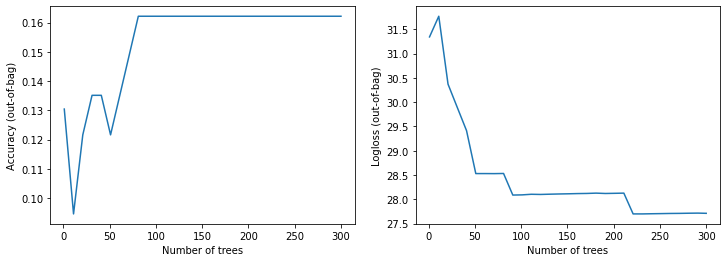

In [ ]:
import matplotlib.pyplot as plt

logs = model_1.make_inspector().training_logs()

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot([log.num_trees for log in logs], [log.evaluation.accuracy for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Accuracy (out-of-bag)")

plt.subplot(1, 2, 2)
plt.plot([log.num_trees for log in logs], [log.evaluation.loss for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Logloss (out-of-bag)")

plt.show()

This dataset is small. You can see the model converging almost immediately.

Let's use TensorBoard:

In [ ]:
# This cell start TensorBoard that can be slow. Load the TensorBoard notebook extension
%load_ext tensorboard
# Google internal version
# %load_ext google3.learning.brain.tensorboard.notebook.extension

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
# Clear existing results (if any)
!rm -fr "/tmp/tensorboard_logs"

In [ ]:
# Export the meta-data to tensorboard.
model_1.make_inspector().export_to_tensorboard("/tmp/tensorboard_logs")

In [ ]:
# docs_infra: no_execute
# Start a tensorboard instance.
%tensorboard --logdir "/tmp/tensorboard_logs"

<!-- <img class="tfo-display-only-on-site" src="images/beginner_tensorboard.png"/> -->


## Re-train the model with a different learning algorithm

The learning algorithm is defined by the model class. For
example, `tfdf.keras.RandomForestModel()` trains a Random Forest, while
`tfdf.keras.GradientBoostedTreesModel()` trains a Gradient Boosted Decision
Trees.

The learning algorithms are listed by calling `tfdf.keras.get_all_models()` or in the
[learner list](https://github.com/google/yggdrasil-decision-forests/manual/learners).

In [ ]:
tfdf.keras.get_all_models()

[tensorflow_decision_forests.keras.RandomForestModel,
 tensorflow_decision_forests.keras.GradientBoostedTreesModel,
 tensorflow_decision_forests.keras.CartModel]

The description of the learning algorithms and their hyper-parameters are also available in the [API reference](https://www.tensorflow.org/decision_forests/api_docs/python/tfdf) and builtin help:

In [ ]:
# help works anywhere.
help(tfdf.keras.RandomForestModel)

# ? only works in ipython or notebooks, it usually opens on a separate panel.
tfdf.keras.RandomForestModel?

## Using a subset of features

The previous example did not specify the features, so all the columns were used
as input feature (except for the label). The following example shows how to
specify input features.

In [ ]:
feature_1 = tfdf.keras.FeatureUsage(name="Past1")
feature_2 = tfdf.keras.FeatureUsage(name="Past2")

all_features = [feature_1, feature_2]

# Note: This model is only trained with two features. It will not be as good as
# the one trained on all features.

model_2 = tfdf.keras.GradientBoostedTreesModel(
    features=all_features, exclude_non_specified_features=True)

model_2.compile(metrics=["accuracy"])
model_2.fit(x=train_ds, validation_data=test_ds)

print(model_2.evaluate(test_ds, return_dict=True))

1/1 [==============================] - 0s 61ms/step - loss: 0.0000e+00 - accuracy: 0.0400
{'loss': 0.0, 'accuracy': 0.03999999910593033}


**Note:** As expected, the accuracy is lower than previously.

**TF-DF** attaches a **semantics** to each feature. This semantics controls how
the feature is used by the model. The following semantics are currently supported:

-   **Numerical**: Generally for quantities or counts with full ordering. For
    example, the age of a person, or the number of items in a bag. Can be a
    float or an integer. Missing values are represented with float(Nan) or with
    an empty sparse tensor.
-   **Categorical**: Generally for a type/class in finite set of possible values
    without ordering. For example, the color RED in the set {RED, BLUE, GREEN}.
    Can be a string or an integer. Missing values are represented as "" (empty
    sting), value -2 or with an empty sparse tensor.
-   **Categorical-Set**: A set of categorical values. Great to represent
    tokenized text. Can be a string or an integer in a sparse tensor or a
    ragged tensor (recommended). The order/index of each item doesn't matter.

If not specified, the semantics is inferred from the representation type and shown in the training logs:

- int, float (dense or sparse) → Numerical semantics.
- str (dense or sparse) → Categorical semantics
- int, str (ragged) → Categorical-Set semantics

In some cases, the inferred semantics is incorrect. For example: An Enum stored as an integer is semantically categorical, but it will be detected as numerical. In this case, you should specify the semantic argument in the input. The `education_num` field of the Adult dataset is classical example.

This dataset doesn't contain such a feature. However, for the demonstration, we will make the model treat the `year` as a categorical feature:

In [ ]:
%set_cell_height 300

feature_1 = tfdf.keras.FeatureUsage(name="Past1", semantic=tfdf.keras.FeatureSemantic.CATEGORICAL)
feature_2 = tfdf.keras.FeatureUsage(name="Past2", semantic=tfdf.keras.FeatureSemantic.CATEGORICAL)
feature_3 = tfdf.keras.FeatureUsage(name="Past3", semantic=tfdf.keras.FeatureSemantic.CATEGORICAL)
all_features = [feature_1, feature_2, feature_3]

model_3 = tfdf.keras.GradientBoostedTreesModel(features=all_features, exclude_non_specified_features=True)
model_3.compile( metrics=["accuracy"])

with sys_pipes():
  model_3.fit(x=train_ds, validation_data=test_ds)

<IPython.core.display.Javascript object>

1/2 [==============>...............] - ETA: 0s

[INFO kernel.cc:746] Start Yggdrasil model training
[INFO kernel.cc:747] Collect training examples
[INFO kernel.cc:392] Number of batches: 2
[INFO kernel.cc:393] Number of examples: 74
[INFO data_spec_inference.cc:289] 72 item(s) have been pruned (i.e. they are considered out of dictionary) for the column Past1 (0 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
[INFO data_spec_inference.cc:289] 56 item(s) have been pruned (i.e. they are considered out of dictionary) for the column Past2 (1 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
[INFO data_spec_inference.cc:289] 38 item(s) have been pruned (i.e. they are considered out of dictionary) for the column Past3 (1 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
[INFO kernel.cc:769] Dataset:
Number of records: 74
Number of columns: 4

Number of columns by type:
	CATEGORICAL: 4 (100%)

Columns:

CATEGORICAL: 4 (100%)
	0: "Past1" CATEGORICAL has-dict v

2/2 [==============================] - 0s 249ms/step - val_loss: 0.0000e+00 - val_accuracy: 0.0400


## Hyper-parameters

**Hyper-parameters** are parameters of the training algorithm that impact
the quality of the final model. They are specified in the model class
constructor. The list of hyper-parameters is visible with the *question mark* colab command (e.g. `?tfdf.keras.GradientBoostedTreesModel`).

Alternatively, you can find them on the [TensorFlow Decision Forest Github](https://github.com/tensorflow/decision-forests/keras/wrappers_pre_generated.py) or the [Yggdrasil Decision Forest documentation](https://github.com/google/yggdrasil_decision_forests/documentation/learners).

The default hyper-parameters of each algorithm matches approximatively the initial publication paper. To ensure consistancy, new features and their matching hyper-parameters are always disable by default. That's why it is a good idea to tune your hyper-parameters.

In [ ]:
# A classical but slighly more complex model.
model_6 = tfdf.keras.GradientBoostedTreesModel(
    num_trees=500, growing_strategy="BEST_FIRST_GLOBAL", max_depth=8)
model_6.fit(x=train_ds)

2/2 [==============================] - 0s 6ms/step


In [ ]:
# A more complex, but possibly, more accurate model.
model_7 = tfdf.keras.GradientBoostedTreesModel(
    num_trees=500,
    growing_strategy="BEST_FIRST_GLOBAL",
    max_depth=8,
    split_axis="SPARSE_OBLIQUE",
    categorical_algorithm="RANDOM",
    )
model_7.fit(x=train_ds)

2/2 [==============================] - 0s 8ms/step


As new training methods are published and implemented, combinaisons of hyper-parameters can emerge as good or almost-always-better than the default parameters. To avoid changing the default hyper-parameter values these good combinaisons are indexed and available as hyper-parameter templates.

For example, the `benchmark_rank1` template is the best combinaison on our internal benchmarks. Those templates are versioned to allow training configuration stability e.g. `benchmark_rank1@v1`.

In [ ]:
# A good template of hyper-parameters.
model_8 = tfdf.keras.GradientBoostedTreesModel(hyperparameter_template="benchmark_rank1")
model_8.fit(x=train_ds)

2/2 [==============================] - 0s 7ms/step


The available tempaltes are available with `predefined_hyperparameters`. Note that different learning algorithms have different templates, even if the name is similar.

In [ ]:
# The hyper-parameter templates of the Gradient Boosted Tree model.
print(tfdf.keras.GradientBoostedTreesModel.predefined_hyperparameters())

[HyperParameterTemplate(name='better_default', version=1, parameters={'growing_strategy': 'BEST_FIRST_GLOBAL'}, description='A configuration that is generally better than the default parameters without being more expensive.'), HyperParameterTemplate(name='benchmark_rank1', version=1, parameters={'growing_strategy': 'BEST_FIRST_GLOBAL', 'categorical_algorithm': 'RANDOM', 'split_axis': 'SPARSE_OBLIQUE', 'sparse_oblique_normalization': 'MIN_MAX', 'sparse_oblique_num_projections_exponent': 1.0}, description='Top ranking hyper-parameters on our benchmark slightly modified to run in reasonable time.')]


## Training a ranking model (possibly relevant)

Finaly, after having trained a classification and a regression models, train a [ranking](https://en.wikipedia.org/wiki/Learning_to_rank) model.

The goal of a ranking is to **order** items by importance. The "value" of
relevance does not matter directly. Ranking a set of *documents* with regard to
a user *query* is an example of ranking problem: It is only important to get the right order, where the top documents matter more.

TF-DF expects for ranking datasets to be presented in a "flat" format. A
document+query dataset might look like that:

query | document_id | feature_1 | feature_2 | relevance/label
----- | ----------- | --------- | --------- | ---------------
cat   | 1           | 0.1       | blue      | 4
cat   | 2           | 0.5       | green     | 1
cat   | 3           | 0.2       | red       | 2
dog   | 4           | NA        | red       | 0
dog   | 5           | 0.2       | red       | 1
dog   | 6           | 0.6       | green     | 1

The *relevance/label* is a floating point numerical value between 0 and 5
(generally between 0 and 4) where 0 means "completely unrelated", 4 means "very
relevant" and 5 means "the same as the query".

Interestingly, decision forests are often good rankers, and many
state-of-the-art ranking models are decision forests.


In [ ]:
%set_cell_height 200

archive_path = tf.keras.utils.get_file("letor.zip",
  "https://download.microsoft.com/download/E/7/E/E7EABEF1-4C7B-4E31-ACE5-73927950ED5E/Letor.zip",
  extract=True)

# Path to the train and test dataset using libsvm format.
raw_dataset_path = os.path.join(os.path.dirname(archive_path),"OHSUMED/Data/All/OHSUMED.txt")

The dataset is stored as a .txt file in a specific format, so first convert it into a csv file.

In [ ]:
def convert_libsvm_to_csv(src_path, dst_path):
  """Converts a libsvm ranking dataset into a flat csv file.
  
  Note: This code is specific to the LETOR3 dataset.
  """
  dst_handle = open(dst_path, "w")
  first_line = True
  for src_line in open(src_path,"r"):
    # Note: The last 3 items are comments.
    items = src_line.split(" ")[:-3]
    relevance = items[0]
    group = items[1].split(":")[1]
    features = [ item.split(":") for item in items[2:]]

    if first_line:
      # Csv header
      dst_handle.write("relevance,group," + ",".join(["f_" + feature[0] for feature in features]) + "\n")
      first_line = False
    dst_handle.write(relevance + ",g_" + group + "," + (",".join([feature[1] for feature in features])) + "\n")
  dst_handle.close()

# Convert the dataset.
csv_dataset_path="/tmp/ohsumed.csv"
convert_libsvm_to_csv(raw_dataset_path, csv_dataset_path)

# Load a dataset into a Pandas Dataframe.
dataset_df = pd.read_csv(csv_dataset_path)

# Display the first 3 examples.
dataset_df.head(3)

In [ ]:
train_ds_pd, test_ds_pd = split_dataset(dataset_df)
print("{} examples in training, {} examples for testing.".format(
    len(train_ds_pd), len(test_ds_pd)))

# Display the first 3 examples of the training dataset.
train_ds_pd.head(3)

In this dataset, the `relevance` defines the ground-truth rank among rows of the same `group`.

In [ ]:
# Name of the relevance and grouping columns.
relevance = "relevance"

ranking_train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_ds_pd, label=relevance, task=tfdf.keras.Task.RANKING)
ranking_test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_ds_pd, label=relevance, task=tfdf.keras.Task.RANKING)

In [ ]:
%set_cell_height 400

model_8 = tfdf.keras.GradientBoostedTreesModel(
    task=tfdf.keras.Task.RANKING,   # Note the task chosen
    ranking_group="group",
    num_trees=50)

with sys_pipes():
  model_8.fit(x=ranking_train_ds)

At this point, keras does not propose any ranking metrics. Instead, the training and validation (a GBDT uses a validation dataset) are shown in the training
logs. In this case the loss is `LAMBDA_MART_NDCG5`, and the final (i.e. at
the end of the training) NDCG (normalized discounted cumulative gain) is `0.510136` (see line `Final model valid-loss: -0.510136`).

Note that the NDCG is a value between 0 and 1. The larget the NDCG, the better
the model. For this reason, the loss to be -NDCG.

As before, the model can be analysed:

In [ ]:
%set_cell_height 400

model_8.summary()

## Training a regression model (not relevant)

The previous example trains a classification model (TF-DF does not differentiate
between binary classification and multi-class classification). In the next
example, train a regression model on the
[Abalone dataset](https://archive.ics.uci.edu/ml/datasets/abalone). The
objective of this dataset is to predict the number of shell's rings of an
abalone.

**Note:** The csv file is assembled by appending UCI's header and data files. No preprocessing was applied.

<center>
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/3/33/LivingAbalone.JPG/800px-LivingAbalone.JPG" width="200"/></center>

In [ ]:
# Download the dataset.
!wget -q https://storage.googleapis.com/download.tensorflow.org/data/abalone_raw.csv -O /tmp/abalone.csv

dataset_df = pd.read_csv("/tmp/abalone.csv")
print(dataset_df.head(3))

  Type  LongestShell  Diameter  ...  VisceraWeight  ShellWeight  Rings
0    M         0.455     0.365  ...         0.1010         0.15     15
1    M         0.350     0.265  ...         0.0485         0.07      7
2    F         0.530     0.420  ...         0.1415         0.21      9

[3 rows x 9 columns]


In [ ]:
# Split the dataset into a training and testing dataset.
train_ds_pd, test_ds_pd = split_dataset(dataset_df)
print("{} examples in training, {} examples for testing.".format(
    len(train_ds_pd), len(test_ds_pd)))

# Name of the label column.
label = "Rings"

train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_ds_pd, label=label, task=tfdf.keras.Task.REGRESSION)
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_ds_pd, label=label, task=tfdf.keras.Task.REGRESSION)

2984 examples in training, 1193 examples for testing.


In [ ]:
%set_cell_height 300

# Configure the model.
model_7 = tfdf.keras.RandomForestModel(task = tfdf.keras.Task.REGRESSION)

# Optional.
model_7.compile(metrics=["mse"])

# Train the model.
with sys_pipes():
  model_7.fit(x=train_ds)

<IPython.core.display.Javascript object>

47/47 [==============================] - 0s 1ms/step


[INFO kernel.cc:746] Start Yggdrasil model training
[INFO kernel.cc:747] Collect training examples
[INFO kernel.cc:392] Number of batches: 47
[INFO kernel.cc:393] Number of examples: 2984
[INFO kernel.cc:769] Dataset:
Number of records: 2984
Number of columns: 9

Number of columns by type:
	NUMERICAL: 8 (88.8889%)
	CATEGORICAL: 1 (11.1111%)

Columns:

NUMERICAL: 8 (88.8889%)
	0: "Diameter" NUMERICAL mean:0.407837 min:0.055 max:0.63 sd:0.0989397
	1: "Height" NUMERICAL mean:0.139564 min:0 max:1.13 sd:0.0430591
	2: "LongestShell" NUMERICAL mean:0.52378 min:0.075 max:0.8 sd:0.119413
	3: "ShellWeight" NUMERICAL mean:0.238117 min:0.0015 max:1.005 sd:0.137906
	4: "ShuckedWeight" NUMERICAL mean:0.358867 min:0.001 max:1.488 sd:0.221317
	6: "VisceraWeight" NUMERICAL mean:0.180245 min:0.0005 max:0.76 sd:0.10943
	7: "WholeWeight" NUMERICAL mean:0.826909 min:0.002 max:2.8255 sd:0.487693
	8: "__LABEL" NUMERICAL mean:9.88773 min:1 max:27 sd:3.1615

CATEGORICAL: 1 (11.1111%)
	5: "Type" CATEGORICAL has

In [ ]:
# Evaluate the model on the test dataset.
evaluation = model_7.evaluate(test_ds, return_dict=True)

print(evaluation)
print()
print(f"MSE: {evaluation['mse']}")
print(f"RMSE: {math.sqrt(evaluation['mse'])}")

47/47 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - mse: 1.8002
{'loss': 0.0, 'mse': 1.800211787223816}

MSE: 1.800211787223816
RMSE: 1.3417197126165419
